# The Midnight Mystery


### Problem Statement

It's a dark and stormy night at the Grand Hotel. Many distinguished guests have gathered for an exclusive gala. At precisely 11:50 PM, a scream pierces the night - one guest has been murdered!

The legendary detective Sherlock Holmes and his assistant Dr. Watson arrive at the scene. They conduct thorough interviews with all surviving guests. Each guest provides information about their whereabouts at the time of the murder and whom they remember seeing.

A crucial piece of evidence is found: a handwritten note clutched in the victim's hand, apparently torn from the murderer during the struggle. The note appears to be written in a distinctive style.

Our task is to help Holmes and Watson identify the most likely suspects.

### Objective
We are provided with `murder_mystery.json` containing:
- **Metadata**: Case details including victim name, murder time, and the mysterious note
- **Interrogations**: Interview reports, each containing:
  - Guest name
  - Their statement about location and sightings
  - Interview timestamp

Our objective is to analyze the evidence to identify the prime suspects. Your investigation should follow these steps:

Combine your findings from all analyses to:
1. Identify the most likely murderer
2. Provide evidence supporting your conclusion
3. Explain any alternative suspects and why they were ruled out


### Expected Result


A final report presenting your conclusion with supporting evidence, and the code.


----

## Data Exploration

We can start by installing and importing all the libraries that could be useful for the task

In [1]:
!pip install openai pandas openpyxl spacy textstat node2vec

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
import community.community_louvain as community_louvain
from transformers import pipeline

from collections import Counter, defaultdict
import spacy
import textstat
import string

import requests
from openai import OpenAI
from google.colab import userdata

import re


Now we can move to explore the **dataset**. We  will start by importing the JSON data and print the most significative metadata, such as the victim name, the infamous note and the guest list.

In [14]:
# Load JSON data
with open('murder_mystery.json', 'r') as file:
    data = json.load(file)

# Extract metadata
metadata = data.get('metadata', {})
victim = metadata.get('victim')
murder_time = metadata.get('murder_time')
victim_note = metadata.get('victim_note')
locations = metadata.get('locations', [])
total_guests = metadata.get('total_guests')
interrogated = metadata.get('interrogated')
interrogated_list = [entry['guest'].strip() for entry in data['interrogations']]
total_guests_list = interrogated_list


# Extract interrogations
interrogations = data.get('interrogations', [])
interrogation_df = pd.DataFrame(interrogations)

# Print basic info
print("Metadata:")
print(json.dumps(metadata, indent=2))
print("\nSample of Interrogations:")
print(interrogation_df.head())


# Print summary of meaningful
print("-----------------------------------------------------------------------")
print(f'\nVictim: {victim}')
print(f'Murder Time: {murder_time}')
print(f'Victim Note: {victim_note}')
print(f'Total guests: {total_guests} ')
print(f'Interrogated: {interrogated} - Guests from interviews: {len(interrogated_list)}')
print(f'Guests list: {total_guests_list}')
print("-----------------------------------------------------------------------")

Metadata:
{
  "case_name": "The Midnight Mystery",
  "victim": "Solicitor Gray",
  "murder_time": "11:50pm",
  "victim_note": "Och, Yer carefully constructed life is built on foundations of sand, and the tide is coming in. I hae spoken wi' the witnesses ye thocht were silenced forever. They telt me aboot the fire, aboot who right started it and why. The insurance money that funded yer rise tae prominence - blood money, every penny of it. Ye smile and charm yer way throo society, but I see the darkness behind yer eyes. Tonight, we end this charade. Meet me and face yer past, or I will ensure everyone knows the truth by morning. The choice is yours.",
  "detective": "Sherlock Holmes",
  "assistant": "Dr. Watson",
  "total_guests": 60,
  "interrogated": 59,
  "locations": [
    "library",
    "ballroom",
    "conservatory",
    "billiard room",
    "study",
    "hall",
    "lounge",
    "dining room",
    "kitchen",
    "cellar",
    "attic",
    "garden",
    "terrace",
    "smoking room

Now we can give a look at the different **interrogation** done by the detective.

In [12]:
# Check the dataframe
interrogation_df['guest'] = interrogation_df['guest'].str.strip()
interrogation_df['statement'] = interrogation_df['statement'].str.strip()
#interrogation_df['timestamp'] = pd.to_datetime(interrogation_df['timestamp'].str.extract(r'(\d{1,2}:\d{2}[ap]m)')[0], format='%I:%M%p')

interrogation_df.head()

,guest,statement,timestamp
0,Professor Blackstone,"At that time, I was in the dining room. I ofte...",Interview conducted at 5:30am
1,Ambassador Indigo,"Well, I can tell you exactly where I was - in ...",Interview conducted at 6:13am
2,Baron Brown,"Well, I can tell you exactly where I was - in ...",Interview conducted at 2:38am
3,Mister Fitzgerald,"I was in the conservatory at 11:50pm exactly, ...",Interview conducted at 4:13am
4,Commodore White,"At that time, I was in the billiard room. I of...",Interview conducted at 2:23am


In [15]:
# prompt: Dataframe in uso: interrogation_df: show the head of dataframe but give more space to statements

# Increase the column width for better display of the 'statement' column
import pandas as pd
pd.set_option('display.max_colwidth', None)
# Display the first few rows of the dataframe
interrogation_df.head()

,guest,statement,timestamp
0,Professor Blackstone,"At that time, I was in the dining room. I often go there in the evenings for admiring the artwork. It's become quite a routine for me. I was in conversation with Baron Nightingale about business matters, I was in conversation with Pemberton about business matters, I spent most of the time chatting with Duchess Summerville, I was in conversation with Lady Crimson about business matters, Grimshaw and I were enjoying the evening together, I was playing cards with Solicitor Beaumont, Grimshaw was there with me, we were having a drink together, Mister Fitzgerald was there with me, we were having a drink together, Sinclair was there with me, we were having a drink together, I spent most of the time chatting with Scarlett, I was in conversation with Judge Winthrop about business matters, Mister Onyx was there with me, we were having a drink together, I was talking with Gold for quite some time, I spent most of the time chatting with Miss Azure, I was playing cards with Archbishop Whitmore, I was playing cards with Brigadier Black, Dean Stonehaven and I were enjoying the evening together, I spent most of the time chatting with Silver, I was in conversation with Ravenswood about business matters, and I was in conversation with Whitmore about business matters. I didn't know what to think when I heard about what happened. I don't know anything about a note. This is the first I'm hearing of it, and I can assure you I had nothing to do with it.",Interview conducted at 5:30am
1,Ambassador Indigo,"Well, I can tell you exactly where I was - in the conservatory, listening to music. I remember because I was there from about 11:30pm until well after midnight. Magistrate Ruby and I were discussing the evening's events, I spent most of the time chatting with Blackwood, Brown and I were discussing the evening's events, I was in conversation with Magistrate Ochre about business matters, I was in conversation with Crimson about business matters, Peacock and I were enjoying the evening together, Silver was there with me, we were having a drink together, I was playing cards with Colonel Ravenswood, Baron Sienna and I were discussing the evening's events, Chancellor Harrington and I were discussing the evening's events, I was in conversation with White about business matters, I was in conversation with Ambassador Beaumont about business matters, I spent most of the time chatting with Dean Stonehaven, Miss Coral and I were enjoying the evening together, White and I were discussing the evening's events, I was in conversation with Counselor Montgomery about business matters, I spent most of the time chatting with Viscount Silver, Ivory and I were enjoying the evening together, Whitehall and I were discussing the evening's events, I was in conversation with Counselor Scarlett about business matters, I spent most of the time chatting with Duchess Cunningham, I was in conversation with Coral about business matters, I was playing cards with Major Whitmore, Northbrook and I were discussing the evening's events, I was in conversation with Onyx about business matters, I was talking with Major Beaumont for quite some time, Black was there with me, we were having a drink together, I was talking with Ambassador Umber for quite some time, Pearl was there with me, we were having a drink together, I was playing cards with Inspector Ravenscroft, I spent most of the time chatting with Mister Coral, I spent most of the time chatting with Doctor Grimshaw, Lady Crimson and I were enjoying the evening together, Mister Fitzgerald was there with me, we were having a drink together, I was playing cards with Sapphire, I spent most of the time chatting with Duchess Summerville, and I was playing cards with Ambassador Northbrook. I couldn't understand why when I heard about what happened. A note? I have no idea what you're talking about. I didn't write anything, and nobody gave me any note either.",Interview conducted at 6:13am
2,

Before moving to the analysis we can check the suggested hints to better target our study.

- People may be mistaken as to who they saw. This is less likely so, if, for example, they were playing cards with a guest, rather than just briefly seeing them pass by.
- Some guests might naturally be more isolated due to their behavior
- Writing styles can reveal more than just dialect - look for patterns


From this, we can think of analyzing multiple metrics and then combine them into a **suspect score**:
- Cosine Similarity: we can study the content of the interrogations to see any similarity with the found note.
- Stylometric Feature Extraction: we can extract several stylistic feature from the interrogation too see if there are any similarity with the style of the found note.
- Graph analysis: we can create different graphs based on the sighting of the guests:
  - Directed graph of sigthing to see if there are any missmatch between different guest statements.
  - Directed graph of reciprocal sighting to extract a sort of grand truth to compare the missmatch and the degree of nodes.
  - Undirected graph to look for clusters of people and check if there are any outliers or people that move between different clusters.

Since the guests may be mistaken as to who they saw based on the activity this may suggest to weight the edge of the graphs based on that.

## Cosine Similarity

We will use Cosine Similarity to measures semantic and textual similarity between the interrogations and the victim.
A strong similarity may indicate that the interrogated guests is the actua author of the victim, and thus the murderer.

In [16]:
# Initialize the sentence-transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the victim note
note_embedding = model.encode(victim_note, convert_to_tensor=True)

# Compute cosine similarity between the note and each guest's statement
similarities = {}
for idx, row in interrogation_df.iterrows():
    guest = row['guest']
    statement = row['statement']
    stmt_embedding = model.encode(statement, convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(note_embedding, stmt_embedding).item()
    similarities[guest] = similarity

# Convert similarities to a sorted DataFrame
similarity_df = pd.DataFrame(sorted(similarities.items(), key=lambda x: x[1], reverse=True),
                             columns=["Guest", "Cosine Similarity"])

# Display the result
print(similarity_df)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

                    Guest  Cosine Similarity
0         Doctor Ashcroft           0.404062
1      Viscount Pemberton           0.396365
2            Baron Sienna           0.390973
3              Lord Green           0.361355
4         Inspector Ivory           0.337435
5         Brigadier Black           0.335596
6    Counselor Montgomery           0.325330
7           Viscount Onyx           0.308643
8          Major Whitmore           0.305079
9           General White           0.298961
10        Ambassador Gold           0.298632
11            Mister Onyx           0.298145
12       Ambassador Umber           0.293304
13       Archbishop Coral           0.290433
14    Duchess Summerville           0.290214
15  Ambassador Northbrook           0.289924
16  Chancellor Harrington           0.289621
17             Earl Pearl           0.288720
18  Solicitor Ravenscroft           0.285726
19          Rector Violet           0.285703
20        Commodore White           0.285347
21     Cou

### Boosting with IDF-weighted

By exploring the dataset we might have noticed that are very commons phrases or concept. In particular when the guest have been asked about the notes they acted all surprised and say they did not knew anything about it (not surprisingly).
We can use a weighted approach to:
1.  **Downweighting Common Phrases:** IDF (Inverse Document Frequency) inherently assigns lower weights to terms that appear frequently across many documents.

2.  **Highlighting Rare/Unique Terms:** Conversely, terms or phrases that appear in only a few statements (low document frequency) will receive a higher IDF weight.

In [18]:
# 1. Prepare data: list of documents (guest statements + victim note)
all_texts = interrogation_df['statement'].tolist() + [victim_note]
guest_names = interrogation_df['guest'].tolist()

# 2. Compute TF-IDF weights (word-level)
vectorizer = TfidfVectorizer()
vectorizer.fit(all_texts)
idf_scores = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))

# 3. Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# 4. Function to compute IDF-weighted embedding
def get_weighted_embedding(text, model, idf_scores):
    tokens = text.split()
    weights = []
    embeddings = []

    for token in tokens:
        token_lower = token.lower()
        if token_lower in idf_scores:
            weight = idf_scores[token_lower]
            embedding = model.encode(token, convert_to_numpy=True)
            embeddings.append(embedding)
            weights.append(weight)

    if not embeddings:
        return np.zeros(model.get_sentence_embedding_dimension())

    embeddings = np.array(embeddings)
    weights = np.array(weights).reshape(-1, 1)
    weighted_embedding = np.sum(embeddings * weights, axis=0) / np.sum(weights)
    return weighted_embedding

# 5. Compute embeddings for guest statements
guest_weighted_embeddings = {
    guest: get_weighted_embedding(text, model, idf_scores)
    for guest, text in zip(guest_names, interrogation_df['statement'])
}

# 6. Compute embedding for victim note
victim_weighted_embedding = get_weighted_embedding(victim_note, model, idf_scores)

# 7. Compute cosine similarities
from sklearn.metrics.pairwise import cosine_similarity

similarities_idf = {}
for guest, emb in guest_weighted_embeddings.items():
    sim = cosine_similarity([victim_weighted_embedding], [emb])[0][0]
    similarities_idf[guest] = sim

# 8. Create DataFrame
weighted_idf_similarity_df = pd.DataFrame(
    sorted(similarities_idf.items(), key=lambda x: x[1], reverse=True),
    columns=['Guest', 'IDF-Weighted Cosine Similarity']
)

print(weighted_idf_similarity_df)

                    Guest  IDF-Weighted Cosine Similarity
0   Solicitor Ravenscroft                        0.944848
1              Miss Azure                        0.944082
2         Dean Stonehaven                        0.942389
3       Countess Grimshaw                        0.942353
4            Count Silver                        0.941695
5       Barrister Peacock                        0.941226
6      Solicitor Beaumont                        0.940299
7           Rector Violet                        0.939945
8          Rector Crimson                        0.939904
9         Ambassador Gold                        0.939816
10        Baron Blackwood                        0.939762
11         Judge Winthrop                        0.939710
12    Archbishop Whitmore                        0.939588
13   Professor Blackstone                        0.938874
14     Counselor Scarlett                        0.938835
15            Baron Brown                        0.938667
16         Maj

### Clustering on weighted IDF

After computing the similarity, it might be interesting to check if there are some cluster to identify some outliers.


Clustering Results:
                    Guest  Cluster
0    Professor Blackstone        2
1       Ambassador Indigo        2
2             Baron Brown        2
3       Mister Fitzgerald        2
4         Commodore White        2
5        Magistrate Ochre        2
6         Doctor Scarlett        2
7              Miss Azure        2
8         Baron Blackwood        2
9      Counselor Scarlett        2
10          Rector Violet        2
11     Barrister Beaumont        0
12        Commodore Ebony        2
13           Baron Sienna        1
14        Magistrate Ruby        2
15     Colonel Ravenswood        2
16         Major Beaumont        2
17             Earl Pearl        2
18        Ambassador Gold        2
19     Duchess Ravenswood        2
20        Brigadier Black        1
21             Miss Coral        2
22            Mister Onyx        2
23  Chancellor Harrington        2
24      Countess Grimshaw        2
25        Doctor Ashcroft        1
26    Archbishop Whitmore        2

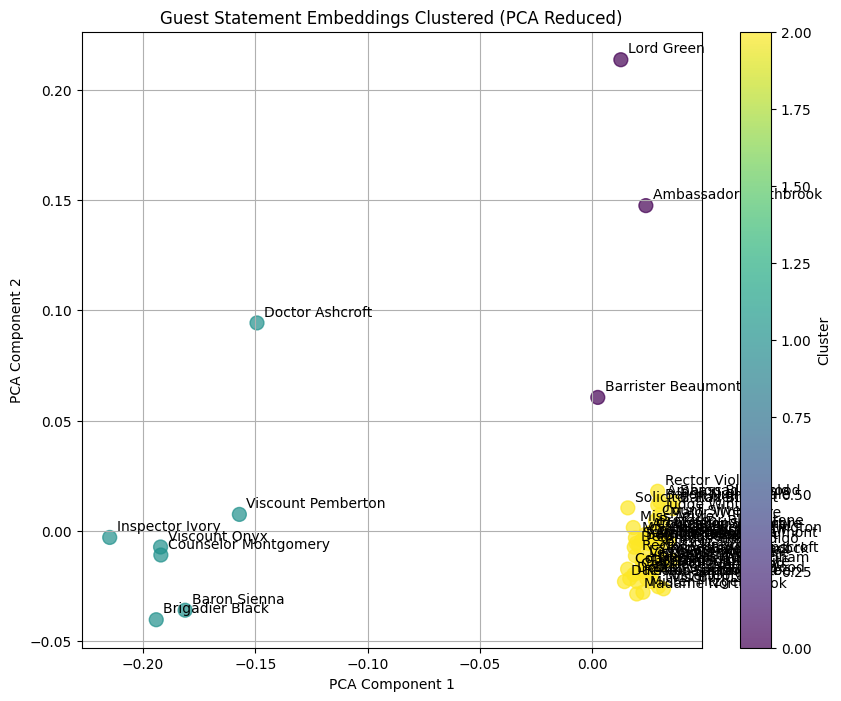

In [20]:
# prompt: Given the above embedding try to perform a clusetering using the libraries already imported and plot it

from sklearn.cluster import KMeans

# Prepare data for clustering
# Using the IDF-Weighted embeddings as features
guest_names = list(guest_weighted_embeddings.keys())
guest_embeddings_list = list(guest_weighted_embeddings.values())
X = np.array(guest_embeddings_list)

# Determine the optimal number of clusters (e.g., using the elbow method)
# For simplicity, let's assume we want to find a few clusters, maybe 2-5.
# You can uncomment the code below to plot the elbow method.
# wcss = []
# for i in range(1, 11):
#     kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
#     kmeans.fit(X)
#     wcss.append(kmeans.inertia_)

# plt.figure(figsize=(10, 5))
# plt.plot(range(1, 11), wcss)
# plt.title('Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()

# Let's choose a number of clusters, for example, 3 based on potential visual inspection or domain knowledge
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Add cluster labels to the dataframe (or create a new one)
clustering_results = pd.DataFrame({'Guest': guest_names, 'Cluster': clusters})
print("\nClustering Results:")
print(clustering_results)

# --- Plotting the Clusters ---

# Reduce dimensions for visualization (e.g., using PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data = X_pca, columns = ['pca_component_1', 'pca_component_2'])
pca_df['Guest'] = guest_names
pca_df['Cluster'] = clusters

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['pca_component_1'], pca_df['pca_component_2'], c=pca_df['Cluster'], cmap='viridis', s=100, alpha=0.7)

# Annotate points with guest names
for i, guest in enumerate(pca_df['Guest']):
    plt.annotate(guest, (pca_df['pca_component_1'][i], pca_df['pca_component_2'][i]), textcoords="offset points", xytext=(5,5), ha='left')

plt.title('Guest Statement Embeddings Clustered (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

We can notice we have two particular small cluster, maybe some suspects?
We can have the size of the cluster as an additional metric of suspect.

In [23]:
# prompt: print the guest name of people in clsuter 0 and 1

# Function to get guests in a specific cluster
def get_guests_in_cluster(cluster_id, clustering_df):
    """Returns a list of guest names in the specified cluster."""
    return clustering_df[clustering_df['Cluster'] == cluster_id]['Guest'].tolist()

# Get and print guests in Cluster 0
guests_cluster_0 = get_guests_in_cluster(0, clustering_results)
print(f"Guests in Cluster 0: {guests_cluster_0}")

# Get and print guests in Cluster 1
guests_cluster_1 = get_guests_in_cluster(1, clustering_results)
print(f"Guests in Cluster 1: {guests_cluster_1}")

Guests in Cluster 0: ['Barrister Beaumont', 'Lord Green', 'Ambassador Northbrook']
Guests in Cluster 1: ['Baron Sienna', 'Brigadier Black', 'Doctor Ashcroft', 'Viscount Pemberton', 'Viscount Onyx', 'Counselor Montgomery', 'Inspector Ivory']


From this we can see

## Stylometric Feature Extraction

After analyzing the content of the interrogations, we can also check the parituclar style of each statements. We can extract:
- Lexical features: avg. sentence length, word length, type-token ratio (vocabulary richness)
- Syntactic style: part-of-speech distribution, passive vs active voice
- Punctuation use: frequency of commas, periods, exclamations
- Stylistic markers: use of contractions, dialects, sentence starters

What we would like to find is a low distance between the features of a guest interrogation and the features of the infamous note, which indicate we may have found our suspect

In [24]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

def extract_stylometric_features(text):
    doc = nlp(text)

    # Lexical features
    num_sentences = len(list(doc.sents))
    num_tokens = len([token for token in doc if token.is_alpha])
    avg_sentence_length = num_tokens / num_sentences if num_sentences else 0
    avg_word_length = sum(len(token.text) for token in doc if token.is_alpha) / num_tokens if num_tokens else 0
    type_token_ratio = len(set(token.text.lower() for token in doc if token.is_alpha)) / num_tokens if num_tokens else 0

    # POS Distribution
    pos_counts = Counter([token.pos_ for token in doc])
    total_pos = sum(pos_counts.values())
    pos_freqs = {f"POS_{k}": v / total_pos for k, v in pos_counts.items()}

    # Passive voice indicator
    passive_count = sum(1 for token in doc if token.dep_ == "auxpass")

    # Punctuation use
    punct_counts = Counter(c for c in text if c in string.punctuation)
    punct_freqs = {f"punct_{k}": v / len(text) for k, v in punct_counts.items()}

    # Readability score
    flesch_score = textstat.flesch_reading_ease(text)

    # Stylistic markers
    dialect_keywords = ['ken', 'dinnae', 'cannae', 'wis', 'nae', 'fer', 'tae']
    dialect_count = sum(text.lower().count(word) for word in dialect_keywords)

    return {
        "avg_sentence_length": avg_sentence_length,
        "avg_word_length": avg_word_length,
        "type_token_ratio": type_token_ratio,
        "passive_voice_count": passive_count,
        "flesch_score": flesch_score,
        "dialect_marker_count": dialect_count,
        **pos_freqs,
        **punct_freqs,
    }




# Extract features for the victim note
victim_features = extract_stylometric_features(victim_note)

# Extract features for all guests
feature_rows = []
for idx, row in interrogation_df.iterrows():
    guest = row['guest']
    statement = row['statement']
    features = extract_stylometric_features(statement)
    features['guest'] = guest
    feature_rows.append(features)

# Convert to DataFrame
stylometry_df = pd.DataFrame(feature_rows)

# Add victim features as a reference row
victim_df = pd.DataFrame([victim_features])
victim_df['guest'] = 'Victim_Note'
stylometry_df = pd.concat([stylometry_df, victim_df], ignore_index=True)

# Optional: normalize features, compute distances, or visualize
stylometry_df.set_index('guest', inplace=True)



# Store index for later
guest_index = stylometry_df.index

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(stylometry_df)

# Reconstruct DataFrame
normalized_df = pd.DataFrame(normalized_features, columns=stylometry_df.columns, index=guest_index)


print(normalized_df)


                       avg_sentence_length  avg_word_length  type_token_ratio  \
guest                                                                           
Professor Blackstone             -0.452689        -0.551918          0.078578   
Ambassador Indigo                 1.075062         1.115458         -0.574470   
Baron Brown                       0.677774        -0.118490         -0.405817   
Mister Fitzgerald                -0.219734         1.434154         -0.333676   
Commodore White                   0.695833         0.357628         -0.528069   
Magistrate Ochre                  0.457460         0.054563         -0.545296   
Doctor Scarlett                  -0.428310         0.678319         -0.128972   
Miss Azure                       -0.143888         0.322132          0.306626   
Baron Blackwood                   1.575283        -0.074252         -0.416018   
Counselor Scarlett                0.717503         0.703471         -0.517770   
Rector Violet               

Before computing the euclidean distance we have to handle the NaN results. We could think of putting the average when missing, but let's check the fields first.

In [25]:
nan_cols = stylometry_df.columns[stylometry_df.isna().any()]
print("Columns with NaNs:", nan_cols.tolist())

Columns with NaNs: ['POS_ADJ', 'POS_PART', 'POS_SCONJ', 'POS_INTJ', 'punct_-', 'punct_:', 'punct_?', 'POS_NUM']


In this case it make sense to put the NaN value to 0, as they reperesent occurrance.
After that we can again normalize it

In [26]:
# Fill all NaNs with 0 (meaning the feature was absent)
stylometry_df_filled = stylometry_df.fillna(0)
# stylometry_df_filled = stylometry_df.fillna(stylometry_df.mean())

# Normalize the filled data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_features = scaler.fit_transform(stylometry_df_filled)

# Reconstruct DataFrame
normalized_df = pd.DataFrame(normalized_features,
                             columns=stylometry_df.columns,
                             index=stylometry_df.index)

# Compute distance
victim_vector = normalized_df.loc['Victim_Note'].values.reshape(1, -1)
distances = euclidean_distances(normalized_df, victim_vector).flatten()

distance_df = pd.DataFrame({
    'Guest': normalized_df.index,
    'Stylometric Distance': distances
}).query("Guest != 'Victim_Note'").sort_values(by='Stylometric Distance')


We can visualize the PCA on the euclidean distance

In [27]:
distance_df_sorted = distance_df.sort_values(by='Stylometric Distance')
print(distance_df_sorted.head(10))

                    Guest  Stylometric Distance
11     Barrister Beaumont             10.701815
39  Solicitor Ravenscroft             10.763052
12        Commodore Ebony             10.855116
25        Doctor Ashcroft             10.864878
22            Mister Onyx             10.875516
30     Solicitor Sinclair             10.931490
0    Professor Blackstone             11.029961
54        Doctor Grimshaw             11.047408
32         Judge Winthrop             11.056301
42     Duchess Cunningham             11.067934


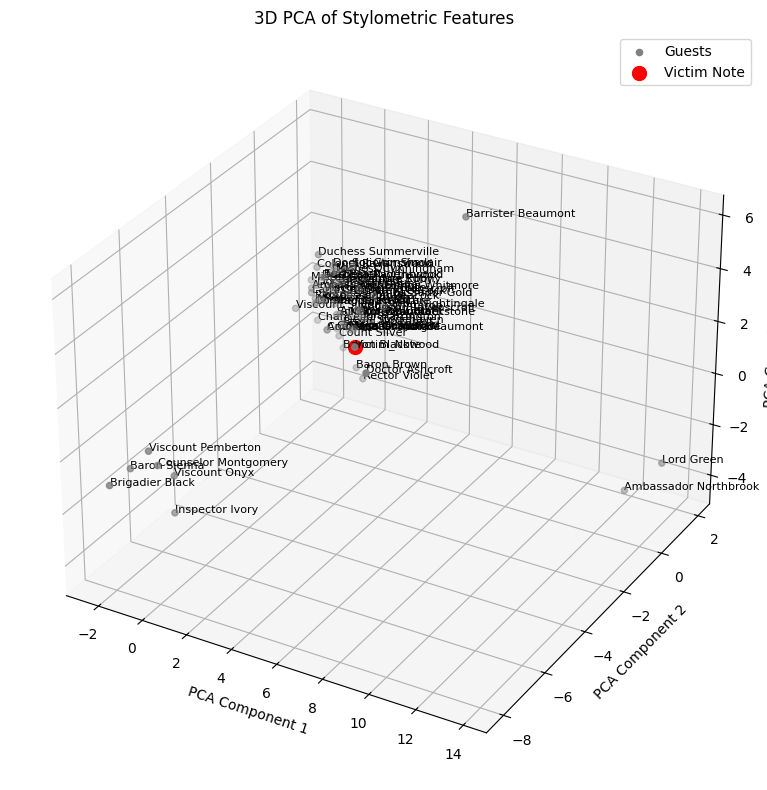

In [28]:
# 3D PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(normalized_df)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all guests in gray
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], color='gray', label='Guests')

# Highlight victim note in red (assumed to be the last row)
ax.scatter(pca_result[-1, 0], pca_result[-1, 1], pca_result[-1, 2], color='red', s=100, label='Victim Note')

# Annotate each point
for i, guest in enumerate(normalized_df.index):
    ax.text(pca_result[i, 0], pca_result[i, 1], pca_result[i, 2], guest, fontsize=8)

# Label axes
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("3D PCA of Stylometric Features")
ax.legend()
plt.tight_layout()
plt.show()

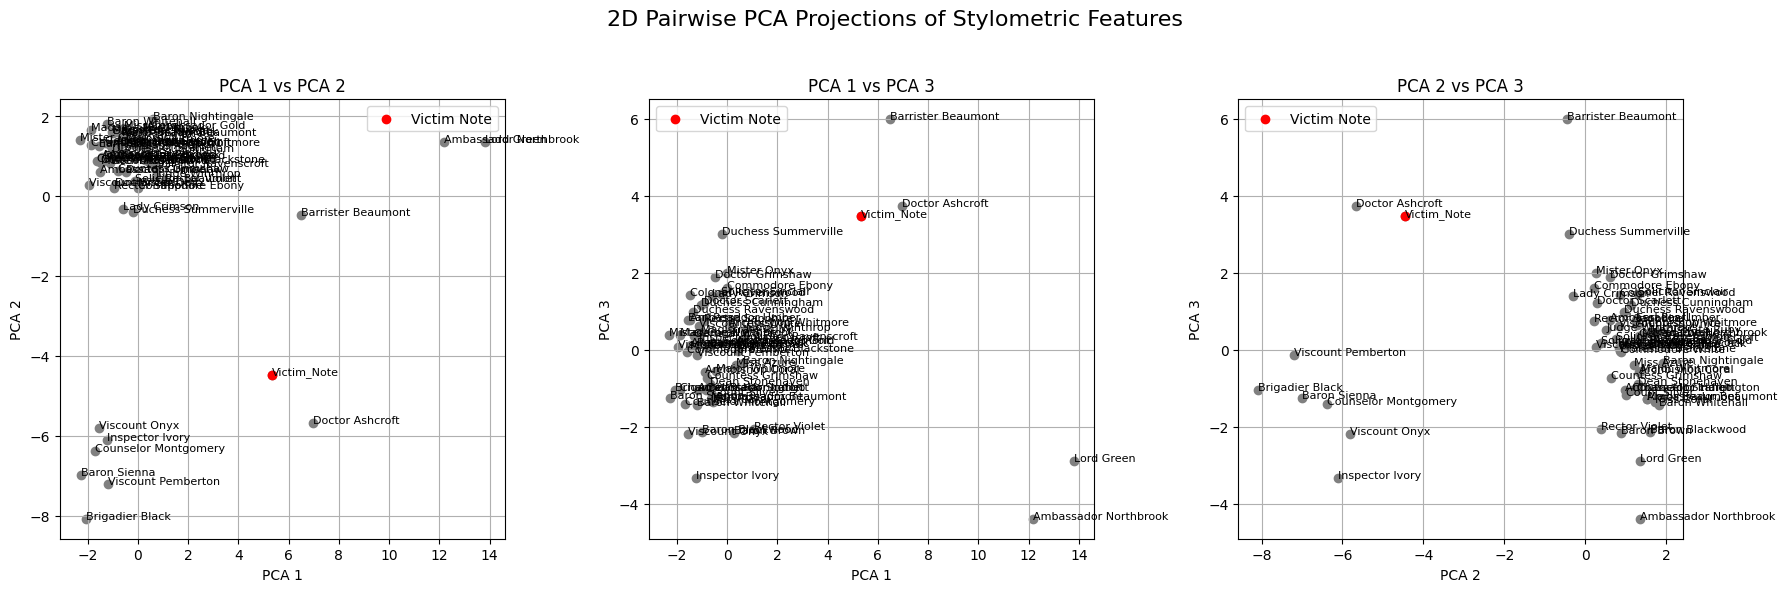

In [29]:
# Guest names for annotation
guest_names = normalized_df.index

# Plotting setup
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pairs of components
pairs = [(0, 1), (0, 2), (1, 2)]
titles = ["PCA 1 vs PCA 2", "PCA 1 vs PCA 3", "PCA 2 vs PCA 3"]

for i, (x_idx, y_idx) in enumerate(pairs):
    ax = axes[i]
    ax.scatter(pca_result[:, x_idx], pca_result[:, y_idx], color='gray')
    ax.scatter(pca_result[-1, x_idx], pca_result[-1, y_idx], color='red', label='Victim Note')  # highlight victim

    # Add labels
    for j, guest in enumerate(guest_names):
        ax.annotate(guest, (pca_result[j, x_idx], pca_result[j, y_idx]), fontsize=8)

    ax.set_xlabel(f"PCA {x_idx+1}")
    ax.set_ylabel(f"PCA {y_idx+1}")
    ax.set_title(titles[i])
    ax.grid(True)
    ax.legend()

plt.suptitle("2D Pairwise PCA Projections of Stylometric Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [30]:
# prompt: Combine the previous weighted idf and euclidean distance (normalize before) to show the current principal suspects

# Assuming weighted_idf_similarity_df and distance_df are already created from previous steps

# Rename columns for clarity before merging
weighted_idf_similarity_df = weighted_idf_similarity_df.rename(columns={'IDF-Weighted Cosine Similarity': 'Weighted_IDF_Similarity'})
distance_df = distance_df.rename(columns={'Stylometric Distance': 'Stylometric_Distance'})

# Merge the two dataframes on the 'Guest' column
# Use an outer join to keep all guests from both lists in case of discrepancies (though there shouldn't be in this case)
suspects_df = pd.merge(weighted_idf_similarity_df, distance_df, on='Guest', how='outer')

# We want high similarity scores (closer to 1) and low distance scores (closer to 0).
# To combine them into a single "suspect score", we can sum the similarity score and the inverse of the distance score.
# A higher combined score will indicate a higher likelihood of being a suspect based on these two metrics.
# We need to handle potential division by zero if distance is exactly 0 (though unlikely with floating points and real data).
# Also, distance can be large, so taking the inverse might make it too small.
# A better approach might be to rank each metric and then sum the ranks, or normalize scores before combining.

# Let's normalize both scores to be between 0 and 1, where 1 is most suspicious.
# For Similarity: Higher is more suspicious, so normalize directly.
# For Distance: Lower is more suspicious, so normalize (max_dist - dist) / (max_dist - min_dist).

# Normalize Weighted IDF Similarity (already between 0 and 1, but good practice)
# Min-Max scaling for similarity where higher is better (0 to 1)
min_sim = suspects_df['Weighted_IDF_Similarity'].min()
max_sim = suspects_df['Weighted_IDF_Similarity'].max()
suspects_df['Normalized_Weighted_IDF_Similarity'] = (suspects_df['Weighted_IDF_Similarity'] - min_sim) / (max_sim - min_sim)

# Normalize Stylometric Distance (lower is better, scale it 0 to 1 where 1 is most suspicious)
min_dist = suspects_df['Stylometric_Distance'].min()
max_dist = suspects_df['Stylometric_Distance'].max()
# Handle case where min_dist == max_dist (all distances are the same)
if max_dist == min_dist:
    suspects_df['Normalized_Stylometric_Distance'] = 0 # or some other value depending on desired outcome
else:
    # Scaling where lower distance results in higher normalized score
    suspects_df['Normalized_Stylometric_Distance'] = (max_dist - suspects_df['Stylometric_Distance']) / (max_dist - min_dist)


# Combine normalized scores into a single metric
# Simple sum: Higher score = higher suspect level
suspects_df['Combined_Suspect_Score'] = suspects_df['Normalized_Weighted_IDF_Similarity'] + suspects_df['Normalized_Stylometric_Distance']

# Sort by the combined score in descending order
principal_suspects_df = suspects_df.sort_values(by='Combined_Suspect_Score', ascending=False)

# Display the results
print("\nPrincipal Suspects based on Combined IDF-Weighted Cosine Similarity and Stylometric Distance:")
print(principal_suspects_df)

# You might want to look at the top N suspects, e.g., top 5
print("\nTop 5 Principal Suspects:")
print(principal_suspects_df.head())


Principal Suspects based on Combined IDF-Weighted Cosine Similarity and Stylometric Distance:
                    Guest  Weighted_IDF_Similarity  Stylometric_Distance  \
53  Solicitor Ravenscroft                 0.944848             10.763052   
18        Commodore Ebony                 0.937989             10.855116   
35         Judge Winthrop                 0.939710             11.056301   
43             Miss Azure                 0.944082             11.405390   
48   Professor Blackstone                 0.938874             11.029961   
47            Mister Onyx                 0.935348             10.875516   
26        Doctor Grimshaw                 0.937479             11.047408   
54     Solicitor Sinclair                 0.935317             10.931490   
13     Barrister Beaumont                 0.930810             10.701815   
7     Archbishop Whitmore                 0.939588             11.374972   
28     Duchess Cunningham                 0.934926             11.067

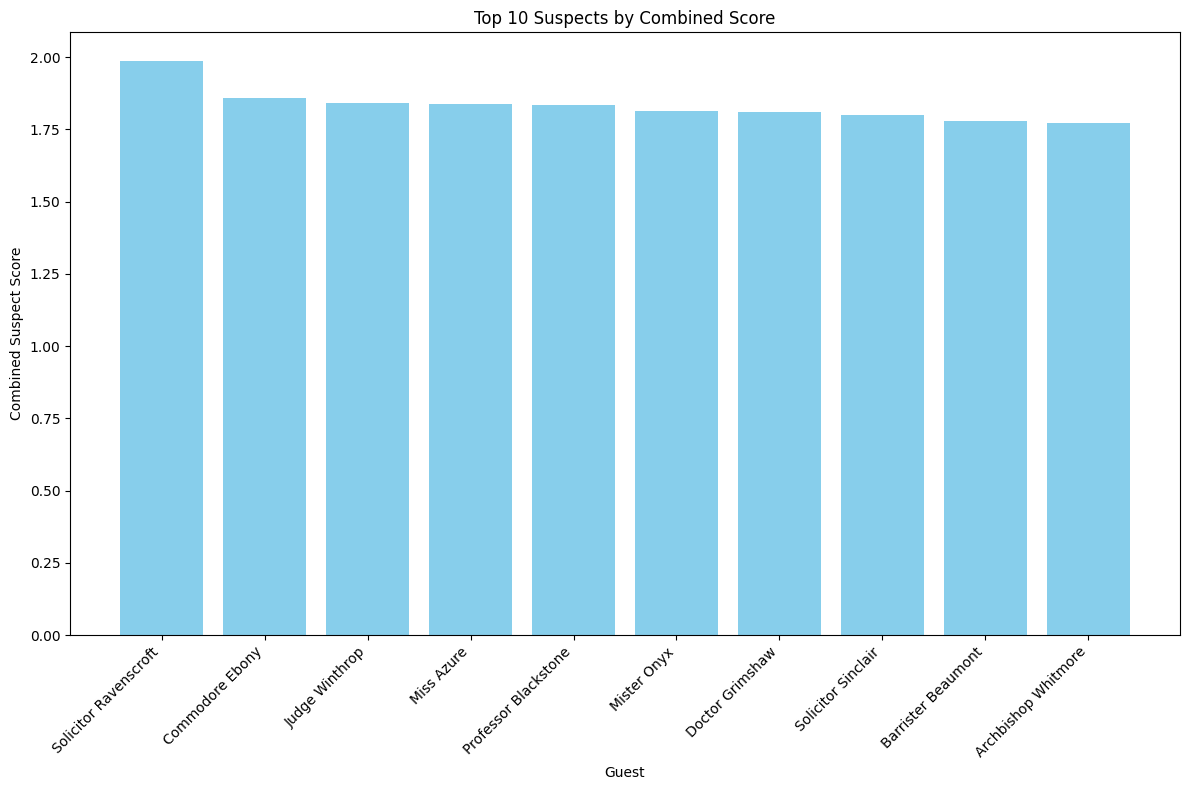

In [33]:
# prompt: plot the combined suspect score for the top suspects

# Get the top N suspects (e.g., top 10)
top_n = 10
top_suspects = principal_suspects_df.head(top_n)

# Plotting the combined suspect score
plt.figure(figsize=(12, 8))
plt.bar(top_suspects['Guest'], top_suspects['Combined_Suspect_Score'], color='skyblue')
plt.xlabel('Guest')
plt.ylabel('Combined Suspect Score')
plt.title(f'Top {top_n} Suspects by Combined Score')
plt.xticks(rotation=45, ha='right') # Rotate guest names for readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

## Extracting Information From Patterns

We can use our interrogations to ask the LLM models to obtain for each guest all the other guests he might have noticed.
Additionally, for each of those sight we are asking to give a confidence score based on the activity they were doing in the meanwhile.

In [35]:
my_secret_key = userdata.get('API_KEY')

# Load OpenRouter API key
client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  # api_key=my_secret_key,
  api_key="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",
)

print(client)

In [37]:
# Build prompt with grouped statements
statements_block = "\n\n".join(
    f"Guest: {row['guest']}\nStatement: {row['statement']}"
    for _, row in interrogation_df.iterrows()
)

prompt = (
    "You are analyzing witness statements from a murder case.\n"
    "Extract the names of all people mentioned by each guest in their statement.\n"
    "Include everyone referenced, whether directly seen, passed by, spoken about, or described."
    # "For each of those reference extract a confidence weight from 0 to 1, e.g., higher weight if, for example, they were playing cards with a guest, rather than just briefly seeing them pass by.\n"
    "Return a valid JSON object in this format:\n"
    "{\n  \"Guest Name\": [\"Seen Person 1\", \"Seen Person 2\", ...],\n  ...\n}\n\n"
    f"STATEMENTS:\n{statements_block}\n\nJSON:"
)

print(prompt)

You are analyzing witness statements from a murder case.
Extract the names of all people mentioned by each guest in their statement.
Include everyone referenced, whether directly seen, passed by, spoken about, or described.Return a valid JSON object in this format:
{
  "Guest Name": ["Seen Person 1", "Seen Person 2", ...],
  ...
}

STATEMENTS:
Guest: Professor Blackstone
Statement: At that time, I was in the dining room. I often go there in the evenings for admiring the artwork. It's become quite a routine for me. I was in conversation with Baron Nightingale about business matters, I was in conversation with Pemberton about business matters, I spent most of the time chatting with Duchess Summerville, I was in conversation with Lady Crimson about business matters, Grimshaw and I were enjoying the evening together, I was playing cards with Solicitor Beaumont, Grimshaw was there with me, we were having a drink together, Mister Fitzgerald was there with me, we were having a drink together,

In [38]:
client = OpenAI(
  api_key=my_secret_key,
  base_url="https://openrouter.ai/api/v1"
)


response = client.chat.completions.create(
  model="openai/gpt-4.1",
  messages=[
    {"role": "system", "content": "You are a precise information extraction assistant. Extract only what is explicitly stated."},
    {"role": "user", "content": prompt}
  ],
  temperature=0.1,
  max_tokens=200
)

In [ ]:
# prompt: I noticed the answer above was truncated, can you split the statement into more request_

try:
    # Attempt to parse the JSON response
    seen_guests_data = json.loads(response.choices[0].message.content)
    print("\nExtracted Seen Guests Data:")
    print(json.dumps(seen_guests_data, indent=2))

    # Optional: Convert to DataFrame for easier manipulation
    seen_guests_df = pd.DataFrame(list(seen_guests_data.items()), columns=['Guest', 'Seen_Guests'])
    print("\nSeen Guests DataFrame:")
    print(seen_guests_df)

except json.JSONDecodeError as e:
    print(f"Error decoding JSON from LLM response: {e}")
    print("Raw LLM response content:")
    print(response.choices[0].message.content)
    seen_guests_data = None # Or handle as needed
    seen_guests_df = None # Or handle as needed
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    seen_guests_data = None
    seen_guests_df = None


In [43]:
# Build prompt with grouped statements
statements_block = "\n\n".join(
    f"Guest: {row['guest']}\nStatement: {row['statement']}"
    for _, row in interrogation_df.iterrows()
)

prompt = (
    "You are analyzing witness statements from a murder case.\n"
    "Extract the names of all people mentioned by each guest in their statement.\n"
    "Include everyone referenced, whether directly seen, passed by, spoken about, or described."
    "For each of those reference extract a confidence weight from 0 to 1, e.g., higher weight if, for example, they were playing cards with a guest, rather than just briefly seeing them pass by.\n"
    "Return a valid JSON object in this format:\n"
    "{\n  \"Guest Name\": [\"Seen Person 1\", \"Seen Person 2\", ...],\n  ...\n}\n\n"
    f"STATEMENTS:\n{statements_block}\n\nJSON:"
)

print(prompt)

You are analyzing witness statements from a murder case.
Extract the names of all people mentioned by each guest in their statement.
Include everyone referenced, whether directly seen, passed by, spoken about, or described.For each of those reference extract a confidence weight from 0 to 1, e.g., higher weight if, for example, they were playing cards with a guest, rather than just briefly seeing them pass by.
Return a valid JSON object in this format:
{
  "Guest Name": ["Seen Person 1", "Seen Person 2", ...],
  ...
}

STATEMENTS:
Guest: Professor Blackstone
Statement: At that time, I was in the dining room. I often go there in the evenings for admiring the artwork. It's become quite a routine for me. I was in conversation with Baron Nightingale about business matters, I was in conversation with Pemberton about business matters, I spent most of the time chatting with Duchess Summerville, I was in conversation with Lady Crimson about business matters, Grimshaw and I were enjoying the eve

Note: we had to split into batches as the JSON was truncated.
**Addittionally the measure of confidence was dropped due to time limit**

In [50]:
import math

# --- Setup
client = OpenAI(
    api_key=my_secret_key,
    base_url="https://openrouter.ai/api/v1"
)

# --- Parameters
BATCH_SIZE = 5  # Number of statements per batch (adjust based on token limits)
SYSTEM_PROMPT = "You are a precise information extraction assistant. Extract only what is explicitly stated."

# --- Helper: format prompt
def build_prompt(batch_df):
    statements_block = "\n\n".join(
        f"Guest: {row['guest']}\nStatement: {row['statement']}"
        for _, row in batch_df.iterrows()
    )
    return (
        "You are analyzing witness statements from a murder case.\n"
        "Extract the names of all people mentioned by each guest in their statement.\n"
        "Include everyone referenced, whether directly seen, passed by, spoken about, or described."
        "Return a valid JSON object in this format:\n"
        "{\n  \"Guest Name\": [[\"Seen Person 1\"], ...],\n  ...\n}\n\n"
        f"STATEMENTS:\n{statements_block}\n\nJSON:"
    )

# --- Helper: merge results
def merge_dicts(dicts):
    final = {}
    for d in dicts:
        for guest, refs in d.items():
            if guest not in final:
                final[guest] = []
            final[guest].extend(refs)
    return final

# --- Batch processing
results = []

for i in range(0, len(interrogation_df), BATCH_SIZE):
    batch_df = interrogation_df.iloc[i:i + BATCH_SIZE]
    prompt = build_prompt(batch_df)

    response = client.chat.completions.create(
        model="openai/gpt-4.1",
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": prompt}
        ],
        temperature=0.1,
    )

    try:
        json_text = response.choices[0].message.content.strip()
        data = json.loads(json_text)
        results.append(data)
    except Exception as e:
        print(f"Failed to parse batch {i // BATCH_SIZE + 1}: {e}")
        print(response.choices[0].message.content)

# --- Final merge
final_result = merge_dicts(results)

# --- Output result
print(json.dumps(final_result, indent=2))


{
  "Professor Blackstone": [
    [
      "Baron Nightingale"
    ],
    [
      "Pemberton"
    ],
    [
      "Duchess Summerville"
    ],
    [
      "Lady Crimson"
    ],
    [
      "Grimshaw"
    ],
    [
      "Solicitor Beaumont"
    ],
    [
      "Mister Fitzgerald"
    ],
    [
      "Sinclair"
    ],
    [
      "Scarlett"
    ],
    [
      "Judge Winthrop"
    ],
    [
      "Mister Onyx"
    ],
    [
      "Gold"
    ],
    [
      "Miss Azure"
    ],
    [
      "Archbishop Whitmore"
    ],
    [
      "Brigadier Black"
    ],
    [
      "Dean Stonehaven"
    ],
    [
      "Silver"
    ],
    [
      "Ravenswood"
    ],
    [
      "Whitmore"
    ]
  ],
  "Ambassador Indigo": [
    [
      "Magistrate Ruby"
    ],
    [
      "Blackwood"
    ],
    [
      "Brown"
    ],
    [
      "Magistrate Ochre"
    ],
    [
      "Crimson"
    ],
    [
      "Peacock"
    ],
    [
      "Silver"
    ],
    [
      "Colonel Ravenswood"
    ],
    [
      "Baron Sienna"
    ],
  

Let see the length of our sight list:

In [54]:
print(len(final_result))

59


In [56]:
final_result


{'Professor Blackstone': [['Baron Nightingale'],
  ['Pemberton'],
  ['Duchess Summerville'],
  ['Lady Crimson'],
  ['Grimshaw'],
  ['Solicitor Beaumont'],
  ['Mister Fitzgerald'],
  ['Sinclair'],
  ['Scarlett'],
  ['Judge Winthrop'],
  ['Mister Onyx'],
  ['Gold'],
  ['Miss Azure'],
  ['Archbishop Whitmore'],
  ['Brigadier Black'],
  ['Dean Stonehaven'],
  ['Silver'],
  ['Ravenswood'],
  ['Whitmore']],
 'Ambassador Indigo': [['Magistrate Ruby'],
  ['Blackwood'],
  ['Brown'],
  ['Magistrate Ochre'],
  ['Crimson'],
  ['Peacock'],
  ['Silver'],
  ['Colonel Ravenswood'],
  ['Baron Sienna'],
  ['Chancellor Harrington'],
  ['White'],
  ['Ambassador Beaumont'],
  ['Dean Stonehaven'],
  ['Miss Coral'],
  ['Whitehall'],
  ['Counselor Montgomery'],
  ['Viscount Silver'],
  ['Ivory'],
  ['Counselor Scarlett'],
  ['Duchess Cunningham'],
  ['Coral'],
  ['Major Whitmore'],
  ['Northbrook'],
  ['Onyx'],
  ['Major Beaumont'],
  ['Black'],
  ['Ambassador Umber'],
  ['Pearl'],
  ['Inspector Ravenscroft']

In [57]:
# prompt: Given the above final_result can you convert to llm_response  = [
#     {"guest": "Sir Gray", "mentioned": [
#         "Ambassador Azure", "Ambassador Black", "General Brown", "Admiral Mustard", "Colonel Coral", "General Azure"
#     ]},
#     {"guest": "Madame Peacock", "mentioned": [
#         "Ambassador Green"
#     ]}]

llm_response = []
for guest, mentioned_list in final_result.items():
  # Convert the list of lists to a single list of strings
  flat_mentioned_list = [item for sublist in mentioned_list for item in sublist]
  llm_response.append({"guest": guest, "mentioned": flat_mentioned_list})

print(json.dumps(llm_response, indent=4))


[
    {
        "guest": "Professor Blackstone",
        "mentioned": [
            "Baron Nightingale",
            "Pemberton",
            "Duchess Summerville",
            "Lady Crimson",
            "Grimshaw",
            "Solicitor Beaumont",
            "Mister Fitzgerald",
            "Sinclair",
            "Scarlett",
            "Judge Winthrop",
            "Mister Onyx",
            "Gold",
            "Miss Azure",
            "Archbishop Whitmore",
            "Brigadier Black",
            "Dean Stonehaven",
            "Silver",
            "Ravenswood",
            "Whitmore"
        ]
    },
    {
        "guest": "Ambassador Indigo",
        "mentioned": [
            "Magistrate Ruby",
            "Blackwood",
            "Brown",
            "Magistrate Ochre",
            "Crimson",
            "Peacock",
            "Silver",
            "Colonel Ravenswood",
            "Baron Sienna",
            "Chancellor Harrington",
            "White",
            "Amb

In [64]:
# prompt: Given the llm_response can you convert it to a final llm_response by changing the cutted name to the entire right name which are contained in interrogated_list + victim_name

def normalize_name(name, name_list):
    """
    Finds the closest match for a potentially truncated name in a list of full names.
    Assumes the names in name_list are the correct, full names.
    """
    # Remove non-alphanumeric characters and convert to lower case for matching
    cleaned_name = re.sub(r'\W+', '', name).lower()

    # Simple direct match or substring check (can be improved with fuzzy matching)
    for full_name in name_list:
        cleaned_full_name = re.sub(r'\W+', '', full_name).lower()
        # Check if the cleaned input name is a substring of the cleaned full name
        if cleaned_name in cleaned_full_name or cleaned_full_name in cleaned_name:
            return full_name
    return name  # Return original name if no match found

# Combine interrogated list and victim name for the list of valid names
all_valid_names = interrogated_list + [victim]

final_llm_response = []
for entry in llm_response:
    normalized_mentioned = [normalize_name(name, all_valid_names) for name in entry['mentioned']]
    final_llm_response.append({"guest": entry['guest'], "mentioned": normalized_mentioned})

print(json.dumps(final_llm_response, indent=4))


[
    {
        "guest": "Professor Blackstone",
        "mentioned": [
            "Baron Nightingale",
            "Viscount Pemberton",
            "Duchess Summerville",
            "Lady Crimson",
            "Countess Grimshaw",
            "Solicitor Beaumont",
            "Mister Fitzgerald",
            "Solicitor Sinclair",
            "Doctor Scarlett",
            "Judge Winthrop",
            "Mister Onyx",
            "Ambassador Gold",
            "Miss Azure",
            "Archbishop Whitmore",
            "Brigadier Black",
            "Dean Stonehaven",
            "Viscount Silver",
            "Colonel Ravenswood",
            "Archbishop Whitmore"
        ]
    },
    {
        "guest": "Ambassador Indigo",
        "mentioned": [
            "Magistrate Ruby",
            "Baron Blackwood",
            "Baron Brown",
            "Magistrate Ochre",
            "Rector Crimson",
            "Barrister Peacock",
            "Viscount Silver",
            "Colonel Rav

In [65]:
# Convert to edges list
edges = []
for entry in final_llm_response:
    guest = entry["guest"]
    for mentioned in entry["mentioned"]:
        edges.append((guest, mentioned))

In [66]:
# Build directed graph of sightings
G = nx.DiGraph()
for entry in final_llm_response:
    guest = entry["guest"]
    for mentioned in entry["mentioned"]:
        G.add_edge(guest, mentioned)

# Identify mismatches: A → B exists, but B → A doesn't
mismatches = []
for u, v in G.edges():
    if not G.has_edge(v, u):
        mismatches.append((u, v))

# Output mismatches
for a, b in mismatches:
    print(f"MISMATCH: {a} mentioned {b}, but {b} did not mention {a}")

MISMATCH: Professor Blackstone mentioned Dean Stonehaven, but Dean Stonehaven did not mention Professor Blackstone
MISMATCH: Professor Blackstone mentioned Viscount Silver, but Viscount Silver did not mention Professor Blackstone
MISMATCH: Professor Blackstone mentioned Colonel Ravenswood, but Colonel Ravenswood did not mention Professor Blackstone
MISMATCH: Baron Nightingale mentioned Barrister Beaumont, but Barrister Beaumont did not mention Baron Nightingale
MISMATCH: Baron Nightingale mentioned Solicitor Ravenscroft, but Solicitor Ravenscroft did not mention Baron Nightingale
MISMATCH: Baron Nightingale mentioned Archbishop Whitmore, but Archbishop Whitmore did not mention Baron Nightingale
MISMATCH: Baron Nightingale mentioned Lady Crimson, but Lady Crimson did not mention Baron Nightingale
MISMATCH: Baron Nightingale mentioned Baron Sienna, but Baron Sienna did not mention Baron Nightingale
MISMATCH: Baron Nightingale mentioned Viscount Silver, but Viscount Silver did not mention

Let's compute how many mismatch for each guest and how many out degree and in degree each guest have


Guest Mismatch and Degree Analysis:
                    Guest  \
58           Count Silver   
49     Duchess Ravenswood   
50      Viscountess White   
34     Counselor Scarlett   
4            Lady Crimson   
43        Doctor Grimshaw   
6      Solicitor Beaumont   
46     Ambassador Peacock   
38         Major Beaumont   
55          Viscount Onyx   
42           Mister Coral   
15        Brigadier Black   
48       Archbishop Coral   
53          General White   
41  Inspector Ravenscroft   
36         Major Whitmore   
29    Ambassador Beaumont   
19      Ambassador Indigo   
7       Mister Fitzgerald   
31        Baron Whitehall   
26           Baron Sienna   
1       Baron Nightingale   
47  Solicitor Ravenscroft   
37      Madame Northbrook   
33        Inspector Ivory   
10         Judge Winthrop   
44        Rector Sapphire   
40             Earl Pearl   
35     Duchess Cunningham   
5       Countess Grimshaw   
2      Viscount Pemberton   
24         Rector Crimson   
22    

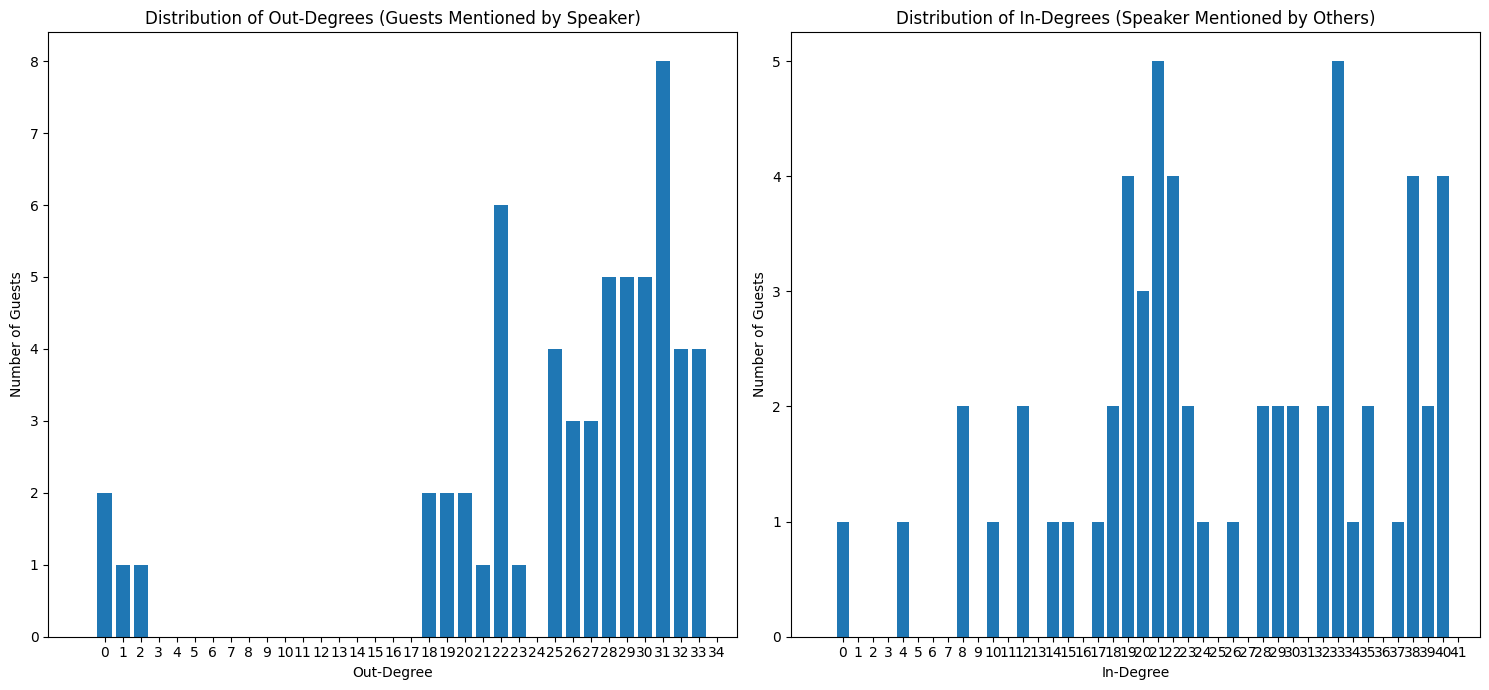

In [67]:
# Calculate mismatches per guest
mismatch_counts = defaultdict(int)
for u, v in mismatches:
    mismatch_counts[u] += 1 # Count mismatch for the source guest (the one who mentioned but wasn't mentioned back)

# Calculate in-degree and out-degree for each guest
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Combine results into a DataFrame for easier viewing
guest_analysis = []
# Ensure all guests (nodes in the graph) are included
all_guests_in_graph = list(G.nodes())

for guest in all_guests_in_graph:
    guest_analysis.append({
        'Guest': guest,
        'Mismatch Count (Mentioned Others Not Mentioning Them Back)': mismatch_counts.get(guest, 0),
        'Out Degree (Mentions Others)': out_degrees.get(guest, 0),
        'In Degree (Mentioned By Others)': in_degrees.get(guest, 0)
    })

analysis_df = pd.DataFrame(guest_analysis).sort_values(by='Mismatch Count (Mentioned Others Not Mentioning Them Back)', ascending=False)

print("\nGuest Mismatch and Degree Analysis:")
print(analysis_df)

# Optional: Visualize degree distribution
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
out_degree_values = list(out_degrees.values())
plt.hist(out_degree_values, bins=range(min(out_degree_values)-1, max(out_degree_values)+1), align='left', rwidth=0.8)
plt.title('Distribution of Out-Degrees (Guests Mentioned by Speaker)')
plt.xlabel('Out-Degree')
plt.ylabel('Number of Guests')
plt.xticks(range(min(out_degree_values), max(out_degree_values)+1))

plt.subplot(1, 2, 2)
in_degree_values = list(in_degrees.values())
plt.hist(in_degree_values, bins=range(min(in_degree_values)-1, max(in_degree_values)+1), align='left', rwidth=0.8)
plt.title('Distribution of In-Degrees (Speaker Mentioned by Others)')
plt.xlabel('In-Degree')
plt.ylabel('Number of Guests')
plt.xticks(range(min(in_degree_values), max(in_degree_values)+1))

plt.tight_layout()
plt.show()

In [68]:
# Directed graph: who mentioned whom
G_directed = nx.DiGraph()
G_directed.add_edges_from([
    (entry["guest"], mentioned)
    for entry in final_llm_response
    for mentioned in entry["mentioned"]
])

# Undirected graph for clustering
G_undirected = G_directed.to_undirected()

# Louvain clustering on undirected graph
partition = community_louvain.best_partition(G_undirected)

# Group nodes by cluster
clusters = defaultdict(list)
for node, group in partition.items():
    clusters[group].append(node)

# Display clusters
for group, members in clusters.items():
    print(f"\nCluster {group}:")
    for name in members:
        print(f" - {name}")


Cluster 2:
 - Professor Blackstone
 - Baron Nightingale
 - Viscount Pemberton
 - Duchess Summerville
 - Lady Crimson
 - Countess Grimshaw
 - Solicitor Beaumont
 - Mister Fitzgerald
 - Solicitor Sinclair
 - Doctor Scarlett
 - Judge Winthrop
 - Mister Onyx
 - Ambassador Gold
 - Miss Azure
 - Archbishop Whitmore
 - Doctor Grimshaw
 - Rector Sapphire
 - Solicitor Ravenscroft
 - Rector Violet
 - Commodore Ebony
 - Barrister Beaumont
 - Lord Green

Cluster 1:
 - Brigadier Black
 - Dean Stonehaven
 - Viscount Silver
 - Colonel Ravenswood
 - Ambassador Indigo
 - Magistrate Ruby
 - Baron Blackwood
 - Baron Brown
 - Magistrate Ochre
 - Barrister Peacock
 - Baron Sienna
 - Chancellor Harrington
 - Commodore White
 - Ambassador Beaumont
 - Miss Coral
 - Baron Whitehall
 - Counselor Montgomery
 - Inspector Ivory
 - Counselor Scarlett
 - Duchess Cunningham
 - Major Whitmore
 - Madame Northbrook
 - Major Beaumont
 - Ambassador Umber
 - Earl Pearl
 - Inspector Ravenscroft
 - Mister Coral
 - Ambassado

In [69]:
pagerank_scores = nx.pagerank(G_directed)
top = sorted(pagerank_scores.items(), key=lambda x: -x[1])[:5]
print("Top influential guests:", top)

# Sort by lowest PageRank
lowest_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1])[:5]

# Output
print("Guests with Lowest PageRank:")
for guest, score in lowest_pagerank:
    print(f"{guest}: {score:.6f}")

Top influential guests: [('Counselor Montgomery', 0.031093113884247417), ('Ambassador Indigo', 0.025520658232983582), ('Rector Crimson', 0.025368400620161866), ('Archbishop Whitmore', 0.024810900188548663), ('Doctor Scarlett', 0.02409754035278335)]
Guests with Lowest PageRank:
Count Silver: 0.002802
Ambassador Northbrook: 0.004804
Doctor Ashcroft: 0.007507
Lady Crimson: 0.008710
Doctor Grimshaw: 0.010077


Let's check who has high out degreee and low page ranks and who has high page rank but low out degree


Median Out-Degree: 28.00
Median PageRank: 0.016211

Guests with High Out-Degree (Mentioning Many) and Low PageRank (Less Mentioned by Others):
                    Guest  Out Degree (Mentions Others)  PageRank
2       Viscountess White                            32  0.012063
11        Brigadier Black                            32  0.013168
0            Count Silver                            31  0.002802
1      Duchess Ravenswood                            31  0.010343
7      Ambassador Peacock                            31  0.012516
9           Viscount Onyx                            31  0.012805
12       Archbishop Coral                            31  0.014583
16    Ambassador Beaumont                            31  0.014990
3      Counselor Scarlett                            30  0.010898
10           Mister Coral                            30  0.014083
14  Inspector Ravenscroft                            29  0.013877

Guests with High PageRank (Mentioned by Many) and Low Out-Degre

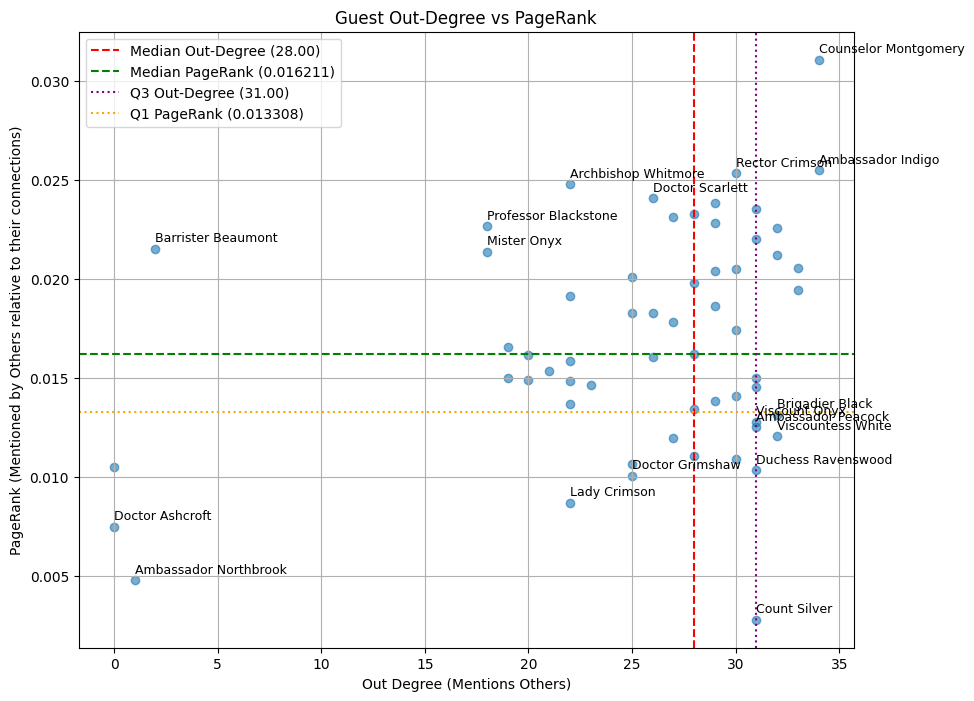

In [70]:
# Convert PageRank dictionary to DataFrame
pagerank_df = pd.DataFrame.from_dict(pagerank_scores, orient='index', columns=['PageRank']).reset_index()
pagerank_df.rename(columns={'index': 'Guest'}, inplace=True)

# Merge with the analysis_df which contains degrees
combined_analysis_df = pd.merge(analysis_df, pagerank_df, on='Guest')

# Find guests with High Out-Degree and Low PageRank
# Define thresholds (these might need adjustment based on the data distribution)
# A simple approach: Above median out-degree, below median PageRank
median_out_degree = combined_analysis_df['Out Degree (Mentions Others)'].median()
median_pagerank = combined_analysis_df['PageRank'].median()

print(f"\nMedian Out-Degree: {median_out_degree:.2f}")
print(f"Median PageRank: {median_pagerank:.6f}")

high_out_low_pagerank = combined_analysis_df[
    (combined_analysis_df['Out Degree (Mentions Others)'] > median_out_degree) &
    (combined_analysis_df['PageRank'] < median_pagerank)
].sort_values(by=['Out Degree (Mentions Others)', 'PageRank'], ascending=[False, True])

print("\nGuests with High Out-Degree (Mentioning Many) and Low PageRank (Less Mentioned by Others):")
print(high_out_low_pagerank[['Guest', 'Out Degree (Mentions Others)', 'PageRank']])

# Find guests with High PageRank and Low Out-Degree
high_pagerank_low_out = combined_analysis_df[
    (combined_analysis_df['PageRank'] > median_pagerank) &
    (combined_analysis_df['Out Degree (Mentions Others)'] < median_out_degree)
].sort_values(by=['PageRank', 'Out Degree (Mentions Others)'], ascending=[False, True])

print("\nGuests with High PageRank (Mentioned by Many) and Low Out-Degree (Mentioning Few):")
print(high_pagerank_low_out[['Guest', 'Out Degree (Mentions Others)', 'PageRank']])

# You can also use quantiles for more robust thresholds
q75_out_degree = combined_analysis_df['Out Degree (Mentions Others)'].quantile(0.75)
q25_pagerank = combined_analysis_df['PageRank'].quantile(0.25)

q75_pagerank = combined_analysis_df['PageRank'].quantile(0.75)
q25_out_degree = combined_analysis_df['Out Degree (Mentions Others)'].quantile(0.25)

print(f"\n75th Percentile Out-Degree: {q75_out_degree:.2f}")
print(f"25th Percentile PageRank: {q25_pagerank:.6f}")
print(f"75th Percentile PageRank: {q75_pagerank:.6f}")
print(f"25th Percentile Out-Degree: {q25_out_degree:.2f}")


high_out_low_pagerank_quantile = combined_analysis_df[
    (combined_analysis_df['Out Degree (Mentions Others)'] >= q75_out_degree) &
    (combined_analysis_df['PageRank'] <= q25_pagerank)
].sort_values(by=['Out Degree (Mentions Others)', 'PageRank'], ascending=[False, True])

print("\nGuests with High Out-Degree (>= 75th Percentile) and Low PageRank (<= 25th Percentile):")
print(high_out_low_pagerank_quantile[['Guest', 'Out Degree (Mentions Others)', 'PageRank']])

high_pagerank_low_out_quantile = combined_analysis_df[
    (combined_analysis_df['PageRank'] >= q75_pagerank) &
    (combined_analysis_df['Out Degree (Mentions Others)'] <= q25_out_degree)
].sort_values(by=['PageRank', 'Out Degree (Mentions Others)'], ascending=[False, True])

print("\nGuests with High PageRank (>= 75th Percentile) and Low Out-Degree (<= 25th Percentile):")
print(high_pagerank_low_out_quantile[['Guest', 'Out Degree (Mentions Others)', 'PageRank']])

# Visualization of Degree vs PageRank
plt.figure(figsize=(10, 8))
plt.scatter(combined_analysis_df['Out Degree (Mentions Others)'], combined_analysis_df['PageRank'], alpha=0.6)

# Optional: Annotate some interesting points
for i, row in combined_analysis_df.iterrows():
    # Annotate guests meeting quantile criteria or top/bottom PageRank
    if row['Guest'] in high_out_low_pagerank_quantile['Guest'].tolist() or \
       row['Guest'] in high_pagerank_low_out_quantile['Guest'].tolist() or \
       row['Guest'] in [item[0] for item in top] or \
       row['Guest'] in [item[0] for item in lowest_pagerank]:
         plt.annotate(row['Guest'], (row['Out Degree (Mentions Others)'], row['PageRank']), fontsize=9, textcoords="offset points", xytext=(0,5))


plt.axvline(x=median_out_degree, color='r', linestyle='--', label=f'Median Out-Degree ({median_out_degree:.2f})')
plt.axhline(y=median_pagerank, color='g', linestyle='--', label=f'Median PageRank ({median_pagerank:.6f})')

plt.axvline(x=q75_out_degree, color='purple', linestyle=':', label=f'Q3 Out-Degree ({q75_out_degree:.2f})')
plt.axhline(y=q25_pagerank, color='orange', linestyle=':', label=f'Q1 PageRank ({q25_pagerank:.6f})')

plt.xlabel("Out Degree (Mentions Others)")
plt.ylabel("PageRank (Mentioned by Others relative to their connections)")
plt.title("Guest Out-Degree vs PageRank")
plt.legend()
plt.grid(True)
plt.show()

We believe the following are interesting:
 - High Page rank but low out degree: the guest it is keeping some information, maybe an accomplice?
 - Low Page rank but high out degree: the guest is probably lying a lot.

-------

## Conclusions

Although we would like to further analyze and extract all possible patters, Sherlock Holmes is waiting for an answer. Thus, we have to sum up.

We have several different suspects criteria:
 - weighted similarity between statement and victim noted (higher -> more suspicious)
 - size of cluster of similarity (smaller -> more suspicious)
 - Euclidean distance between style feature of statement and victim note (smaller -> more suspicious)
 - count of missmatch in sighting (higher -> more suspicious)
 - size of Louvain custers (smaller -> more suspicious)
 - high pagerank and low out degree is suspicious as partner in crime
 - low pagerank and high out degree is suspicious as could it means lot of lies

We will assign a score to each suspect in each criteria. Then we will weight the score based our intuition, which is that the similarity of the notes can give us more confident insight of the murderer, thus they will have a higher weight.

In [89]:
# Let's define the weights for each metric. These are subjective and based on the reasoning above.
# They should sum to 1 for ease of interpretation, although normalization will handle this implicitly.
weights = {
    'Weighted_IDF_Similarity': 0.3,  # Strongest indicator if style/content matches the note
    'Stylometric_Distance': 0.25,   # Also related to the note's authorship
    'Mismatch Count (Mentioned Others Not Mentioning Them Back)': 0.15, # Lying/dishonesty
    'PageRank_Low_Out_High': 0.1, # Potential accomplice (High PR, Low Out)
    'PageRank_High_Out_Low': 0.1, # Potential liar (Low PR, High Out)
    'Cluster_Size_Similarity': 0.05, # Outlier in content similarity
    'Cluster_Size_Louvain': 0.05     # Outlier in social network structure
}

# Check if weights sum to 1 (approximately)
print(f"Sum of weights: {sum(weights.values()):.2f}")

Sum of weights: 1.00


In [90]:
suspect_scores = {}
for guest in total_guests_list:
    suspect_scores[guest] = 0

# weighted_idf_similarity_df - already sorted
idf_similarity = weighted_idf_similarity_df.head(10)['Guest']
print(f'IDF SIMILARITY: {idf_similarity}')
for i, suspect in enumerate(idf_similarity):
  if (i == 0):
    suspect_scores[suspect] += 5 * weights['Weighted_IDF_Similarity']
  elif (i == 1 or i == 2 or i==3):
    suspect_scores[suspect] += 3 * weights['Weighted_IDF_Similarity']
  else:
    suspect_scores[suspect] += 1 * weights['Weighted_IDF_Similarity']



IDF SIMILARITY: 0    Solicitor Ravenscroft
1               Miss Azure
2          Dean Stonehaven
3        Countess Grimshaw
4             Count Silver
5        Barrister Peacock
6       Solicitor Beaumont
7            Rector Violet
8           Rector Crimson
9          Ambassador Gold
Name: Guest, dtype: object


In [91]:
# weighted_idf_similarity_df - already sorted
euclidean_distances = distance_df_sorted.head(10)['Guest']
print(f'Euclidean Distance - Style Feature: {euclidean_distances}')
for i, suspect in enumerate(euclidean_distances):
  if (i == 0):
    suspect_scores[suspect] += 5 * weights['Stylometric_Distance']
  elif (i == 1 or i == 2 or i==3):
    suspect_scores[suspect] += 3 * weights['Stylometric_Distance']
  else:
    suspect_scores[suspect] += 1 * weights['Stylometric_Distance']

Euclidean Distance - Style Feature: 11       Barrister Beaumont
39    Solicitor Ravenscroft
12          Commodore Ebony
25          Doctor Ashcroft
22              Mister Onyx
30       Solicitor Sinclair
0      Professor Blackstone
54          Doctor Grimshaw
32           Judge Winthrop
42       Duchess Cunningham
Name: Guest, dtype: object


In [92]:
analysis_df_top10_mismatch = analysis_df.sort_values(by='Mismatch Count (Mentioned Others Not Mentioning Them Back)', ascending=False).head(10)['Guest']
print(f'Mismatch Count: {analysis_df_top10_mismatch}')
for i, suspect in enumerate(analysis_df_top10_mismatch):
  if (i == 0):
    suspect_scores[suspect] += 5 * weights['Mismatch Count (Mentioned Others Not Mentioning Them Back)']
  elif (i == 1 or i == 2 or i==3):
    suspect_scores[suspect] += 3 * weights['Mismatch Count (Mentioned Others Not Mentioning Them Back)']
  else:
    suspect_scores[suspect] += 1 * weights['Mismatch Count (Mentioned Others Not Mentioning Them Back)']

Mismatch Count: 58          Count Silver
49    Duchess Ravenswood
50     Viscountess White
34    Counselor Scarlett
4           Lady Crimson
43       Doctor Grimshaw
6     Solicitor Beaumont
46    Ambassador Peacock
38        Major Beaumont
55         Viscount Onyx
Name: Guest, dtype: object


In [93]:
# prompt: as done above do the same for page rank lowest and out degrees and high page rank and low degree

# Guests with lowest PageRank and high out-degree
low_pagerank_high_out = combined_analysis_df[
    (combined_analysis_df['PageRank'] <= q25_pagerank) &
    (combined_analysis_df['Out Degree (Mentions Others)'] >= q75_out_degree)
].sort_values(by=['PageRank', 'Out Degree (Mentions Others)'], ascending=[True, False])

print("\nGuests with Low PageRank (<= 25th Percentile) and High Out-Degree (>= 75th Percentile) - Potential Liars:")
print(low_pagerank_high_out[['Guest', 'Out Degree (Mentions Others)', 'PageRank']])

low_pagerank_high_out_guests = low_pagerank_high_out['Guest'].tolist()
for suspect in low_pagerank_high_out_guests:
    suspect_scores[suspect] += 5 * weights['PageRank_High_Out_Low']


# Guests with high PageRank and low out-degree
high_pagerank_low_out = combined_analysis_df[
    (combined_analysis_df['PageRank'] >= q75_pagerank) &
    (combined_analysis_df['Out Degree (Mentions Others)'] <= q25_out_degree)
].sort_values(by=['PageRank', 'Out Degree (Mentions Others)'], ascending=[False, True])

print("\nGuests with High PageRank (>= 75th Percentile) and Low Out-Degree (<= 25th Percentile) - Potential Accomplices:")
print(high_pagerank_low_out[['Guest', 'Out Degree (Mentions Others)', 'PageRank']])

high_pagerank_low_out_guests = high_pagerank_low_out['Guest'].tolist()
for suspect in high_pagerank_low_out_guests:
    suspect_scores[suspect] += 5 * weights['PageRank_Low_Out_High']


# Analyze cluster sizes from IDF-Weighted Cosine Similarity Clustering
# Compute cluster sizes
similarity_cluster_sizes = clustering_results['Cluster'].value_counts()
print("\nSimilarity Cluster Sizes:")
print(similarity_cluster_sizes)

# Guests in the smallest similarity clusters are more likely outliers
# Sort clusters by size
sorted_sim_clusters = similarity_cluster_sizes.sort_values(ascending=True)

# Assign score based on smallest clusters (e.g., top 2 smallest)
for i, (cluster_id, size) in enumerate(sorted_sim_clusters.items()):
    guests_in_cluster = get_guests_in_cluster(cluster_id, clustering_results)
    print(f"Similarity Cluster {cluster_id} (Size: {size}): {guests_in_cluster}")
    score_multiplier = 5 if i == 0 else (3 if i == 1 else 1) # Higher score for smaller clusters
    for guest in guests_in_cluster:
        suspect_scores[guest] += score_multiplier * weights['Cluster_Size_Similarity']


# Analyze cluster sizes from Louvain Clustering on Undirected Graph
louvain_cluster_sizes = pd.Series(partition).value_counts()
print("\nLouvain Cluster Sizes:")
print(louvain_cluster_sizes)

# Guests in the smallest Louvain clusters are more likely outliers in the social network
# Sort clusters by size
sorted_louvain_clusters = louvain_cluster_sizes.sort_values(ascending=True)

# Assign score based on smallest clusters (e.g., top 2 smallest)
for i, (cluster_id, size) in enumerate(sorted_louvain_clusters.items()):
    guests_in_cluster = clusters[cluster_id] # Use the dictionary created earlier
    print(f"Louvain Cluster {cluster_id} (Size: {size}): {guests_in_cluster}")
    score_multiplier = 5 if i == 0 else (3 if i == 1 else 1) # Higher score for smaller clusters
    for guest in guests_in_cluster:
        suspect_scores[guest] += score_multiplier * weights['Cluster_Size_Louvain']


# Convert final scores to DataFrame and sort
final_suspect_ranking = pd.DataFrame(list(suspect_scores.items()), columns=['Guest', 'Final_Suspect_Score'])
final_suspect_ranking = final_suspect_ranking.sort_values(by='Final_Suspect_Score', ascending=False)

print("\nFinal Suspect Ranking:")
print(final_suspect_ranking)


Guests with Low PageRank (<= 25th Percentile) and High Out-Degree (>= 75th Percentile) - Potential Liars:
                 Guest  Out Degree (Mentions Others)  PageRank
0         Count Silver                            31  0.002802
1   Duchess Ravenswood                            31  0.010343
2    Viscountess White                            32  0.012063
7   Ambassador Peacock                            31  0.012516
9        Viscount Onyx                            31  0.012805
11     Brigadier Black                            32  0.013168

Guests with High PageRank (>= 75th Percentile) and Low Out-Degree (<= 25th Percentile) - Potential Accomplices:
                   Guest  Out Degree (Mentions Others)  PageRank
53   Archbishop Whitmore                            22  0.024811
54  Professor Blackstone                            18  0.022681
55    Barrister Beaumont                             2  0.021548
40           Mister Onyx                            18  0.021397

Similarity Cl

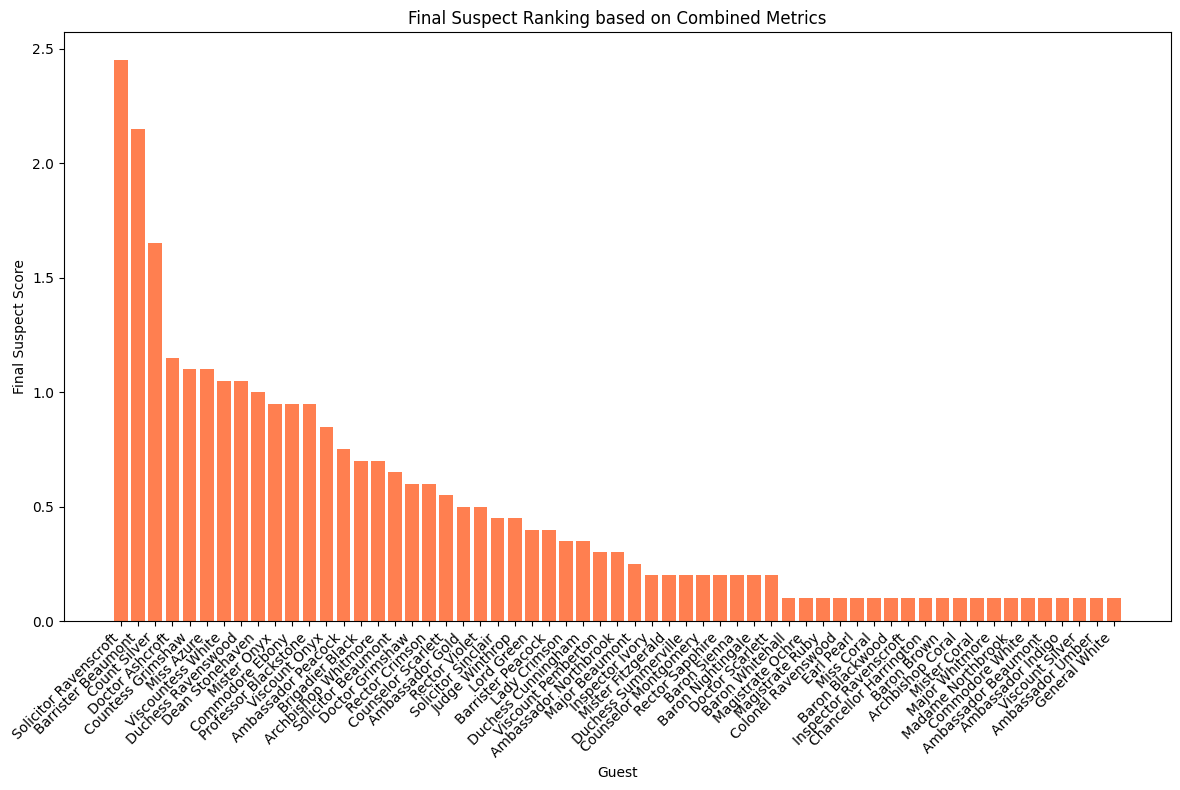

In [94]:
# Visualize the final scores
plt.figure(figsize=(12, 8))
plt.bar(final_suspect_ranking['Guest'], final_suspect_ranking['Final_Suspect_Score'], color='coral')
plt.xlabel('Guest')
plt.ylabel('Final Suspect Score')
plt.title('Final Suspect Ranking based on Combined Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

And with a noticeble margin the our top candidate for the murder is **Solicitor Ravenscroft**.
The main component for his condemnation his high chances that he was the one writing the note found in the victim hand. Although he was not the highest candidate form the graph analysis, the higher weight on the note similarity lead to be him suspect no. 1.